# Music Genre Classification task with neural networks from the PyTorch library.

The GTZAN dataset is a commonly used collection of audio tracks for research in music genre classification tasks. This dataset is widely utilized in the machine learning and audio processing communities for benchmarking algorithms and models.

## Overview

Number of Tracks: 1000\
Duration per Track: 30 seconds\
Genres: 10 (blues, classical, country, disco, hip-hop, jazz, metal, pop, reggae, rock)\
Tracks per Genre: 100

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import librosa

In [2]:
data = pd.read_csv('./datasets/genre-dataset/features_30_sec.csv')

In [3]:
#So i can see the full dat
# Adjust display settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
# Extract features and labels
features = data.drop(columns=['filename', 'label','length'])
labels = data['label']
#Number of features

In [5]:
# Convert to NumPy arrays
X = features.to_numpy()
y = labels.to_numpy()
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print (X_train.shape, X_test.shape)

(900, 57) (100, 57)


In [6]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [109]:
# Define the model
dropout=0.3
class MusicGenreClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MusicGenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(dropout)
        
        self.fc2 = nn.Linear(2048, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(dropout)
        
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(dropout)
        
        self.out = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.out(x)
        return x

        x = self.out(x)
        return x

In [110]:
input_size = X_train.shape[1]
num_classes = len(set(y_train))
model = MusicGenreClassifier(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}')

# Save the trained model
torch.save(model.state_dict(), './music_genre_classifier.pth')

Epoch 1/30, Loss: 2.0101
Epoch 2/30, Loss: 1.7412
Epoch 3/30, Loss: 1.5608
Epoch 4/30, Loss: 1.3905
Epoch 5/30, Loss: 1.2608
Epoch 6/30, Loss: 1.1103
Epoch 7/30, Loss: 1.0266
Epoch 8/30, Loss: 0.9480
Epoch 9/30, Loss: 0.9168
Epoch 10/30, Loss: 0.8691
Epoch 11/30, Loss: 0.7905
Epoch 12/30, Loss: 0.8124
Epoch 13/30, Loss: 0.7709
Epoch 14/30, Loss: 0.8384
Epoch 15/30, Loss: 0.7320
Epoch 16/30, Loss: 0.7499
Epoch 17/30, Loss: 0.6619
Epoch 18/30, Loss: 0.5816
Epoch 19/30, Loss: 0.6566
Epoch 20/30, Loss: 0.6730
Epoch 21/30, Loss: 0.6054
Epoch 22/30, Loss: 0.6044
Epoch 23/30, Loss: 0.5336
Epoch 24/30, Loss: 0.5784
Epoch 25/30, Loss: 0.5530
Epoch 26/30, Loss: 0.6306
Epoch 27/30, Loss: 0.4527
Epoch 28/30, Loss: 0.6051
Epoch 29/30, Loss: 0.4615
Epoch 30/30, Loss: 0.4500


In [111]:
#Load the saved model instead
try:
    model.load_state_dict(torch.load('./music_genre_classifier.pth'))
    print('Model Loaded')
except FileNotFoundError:
    print('File cannot be found')

Model Loaded


In [112]:
# Testing loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        #outputs,1 is returning the first maximum
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(targets.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.7800


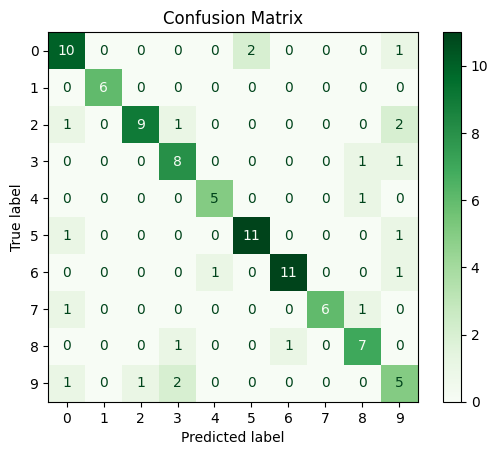

In [113]:
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

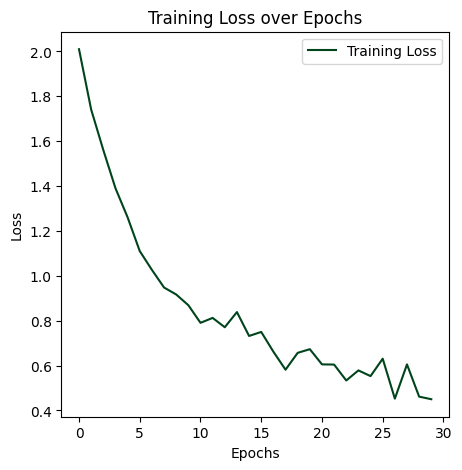

In [114]:
# Plotting training loss
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Training Loss',color=plt.cm.Greens(1.0))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [115]:
# Paths for custom test data
wav_path_1 = './datasets/custom-music/enemyinside.wav'
wav_path_2 = './datasets/custom-music/getlucky.wav'
wav_path_3 = './datasets/custom-music/onemoretime.wav'
wav_path_4 = './datasets/custom-music/thrillisgone.wav'
audio_files=[wav_path_1,wav_path_2,wav_path_3,wav_path_4]

In [95]:
def extract_features(wav_path):
    #Convert to 22050
    y, sr = librosa.load(wav_path, sr=22050,duration=30.0)
    #Convert to mono
    y = librosa.to_mono(y)
    features = {}
    
    #Chroma
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_stft_mean'] = f"{np.mean(chroma_stft):.6f}"
    features['chroma_stft_var'] = f"{np.var(chroma_stft):.6f}"
    
    #RMS
    rms = librosa.feature.rms(y=y)
    features['rms_mean'] = f"{np.mean(rms):.6f}"
    features['rms_var'] = f"{np.var(rms):.6f}"
    
    #Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = f"{np.mean(spectral_centroid):.6f}"
    features['spectral_centroid_var'] = f"{np.var(spectral_centroid):.6f}"
    
    #Spectral Bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = f"{np.mean(spectral_bandwidth):.6f}"
    features['spectral_bandwidth_var'] = f"{np.var(spectral_bandwidth):.6f}"
    
    #Spectral Rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['rolloff_mean'] = f"{np.mean(rolloff):.6f}"
    features['rolloff_var'] = f"{np.var(rolloff):.6f}"
    
    #Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    features['zero_crossing_rate_mean'] = f"{np.mean(zero_crossing_rate):.6f}"
    features['zero_crossing_rate_var'] = f"{np.var(zero_crossing_rate):.6f}"
    
    #Harmonic and Percussive components
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    harmony = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
    perceptr = librosa.feature.tonnetz(y=y_percussive, sr=sr)
    features['harmony_mean'] = f"{np.mean(harmony):.6f}"
    features['harmony_var'] = f"{np.var(harmony):.6f}"
    features['perceptr_mean'] = f"{np.mean(perceptr):.6f}"
    features['perceptr_var'] = f"{np.var(perceptr):.6f}"
    
    #Tempo
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo[0]
    
    #MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    for i in range(1, 21):
        features[f'mfcc{i}_mean'] = f"{np.mean(mfccs[i-1]):.6f}" 
        features[f'mfcc{i}_var'] = f"{np.var(mfccs[i-1]):.6f}"

    return features

features_arr=[]
for file in audio_files:
    test_features = extract_features(file)
    features_arr.append(list(test_features.values()))
print(f'Features extraced for {len(features_arr)} files')

Features extraced for 4 files


In [116]:
#Convert to np array and optimise
test_features_np = np.array(features_arr)
test_features_np_optimised = scaler.transform(test_features_np)
new_data_tensor = torch.tensor(test_features_np_optimised, dtype=torch.float32)


Probabilities for ./datasets/custom-music/enemyinside.wav 

blues: 0.0035
classical: 0.0003
country: 0.0001
disco: 0.0109
hiphop: 0.0091
jazz: 0.0004
metal: 0.9437
pop: 0.0011
reggae: 0.0012
rock: 0.0297

Probabilities for ./datasets/custom-music/getlucky.wav 

blues: 0.0058
classical: 0.0028
country: 0.0117
disco: 0.0337
hiphop: 0.0576
jazz: 0.0090
metal: 0.0068
pop: 0.0290
reggae: 0.8136
rock: 0.0299

Probabilities for ./datasets/custom-music/onemoretime.wav 

blues: 0.0113
classical: 0.0057
country: 0.0087
disco: 0.4725
hiphop: 0.2980
jazz: 0.0246
metal: 0.0081
pop: 0.0173
reggae: 0.0892
rock: 0.0646

Probabilities for ./datasets/custom-music/thrillisgone.wav 

blues: 0.0315
classical: 0.0514
country: 0.0226
disco: 0.1175
hiphop: 0.0270
jazz: 0.4616
metal: 0.0253
pop: 0.0238
reggae: 0.1258
rock: 0.1135


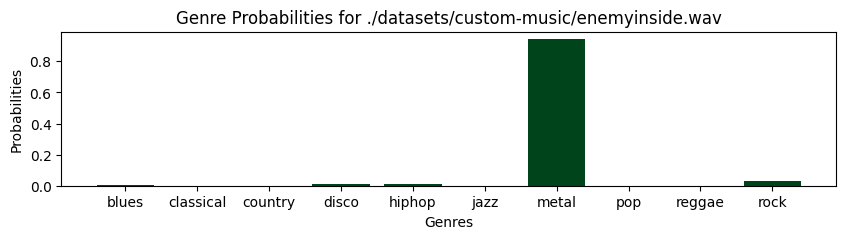

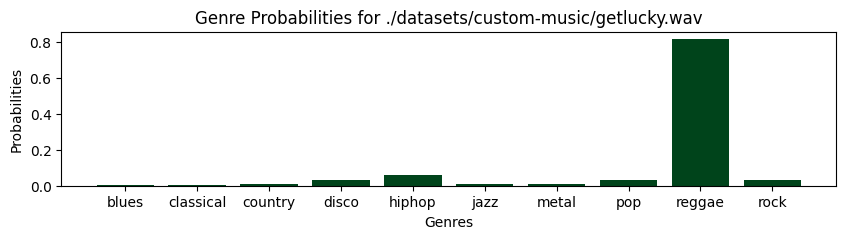

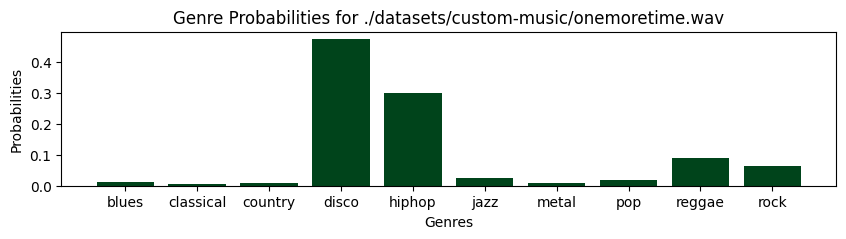

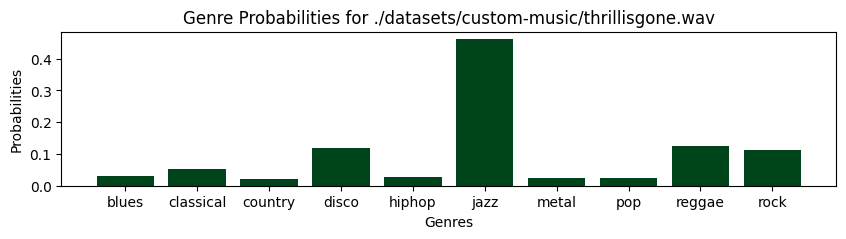

In [117]:
new_data_loader = DataLoader(new_data_tensor, batch_size=32, shuffle=False)
#Don't really need batches for this but let's keep it consistent
model.eval()
probabilities = []

with torch.no_grad():
    for inputs in new_data_loader:
        # Forward pass
        outputs = model(inputs)
        probabilities_batch = torch.softmax(outputs, dim=1)
        # Convert probabilities to numpy array
        probabilities_batch = probabilities_batch.numpy()
        # Append probabilities_batch to probabilities
        probabilities.append(probabilities_batch)

decoded_labels=label_encoder.inverse_transform(np.arange(10))
#Print probabilities and label encods
for batch_probs in probabilities:
    for j,probs in enumerate(batch_probs):
        #Uncomment this if you need to see the actual values but graph is more than enough at this stage
        
        print("\nProbabilities for",audio_files[j],'\n')
        for i, prob in enumerate(probs):
            print(f"{decoded_labels[i]}: {prob:.4f}")
        
        plt.figure(figsize=(10, 2))
        plt.bar(list(decoded_labels), list(probs), color=plt.cm.Greens(1.0))
        # Add title and labels
        plt.title(f'Genre Probabilities for {audio_files[j]}')
        plt.xlabel('Genres')
        plt.ylabel('Probabilities')